In [13]:
from typing import Annotated
from typing_extensions import TypedDict

In [14]:
!pip install arxiv wikipedia

In [15]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [16]:
wiki_tool.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shahrukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 100'

In [17]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [18]:
tools=[wiki_tool]

In [19]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [20]:
from langgraph.graph import StateGraph,START,END

In [21]:
graph_builder= StateGraph(State)


In [22]:
from langchain_groq import ChatGroq

In [23]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [24]:

groq_api_key=os.getenv("GROQ_API_KEY")

In [25]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7fe429adda10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7fe429b30b90>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [26]:
llm_with_tools=llm.bind_tools(tools=tools)

In [27]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [28]:
from langgraph.prebuilt import ToolNode,tools_condition

In [29]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [30]:
graph=graph_builder.compile()

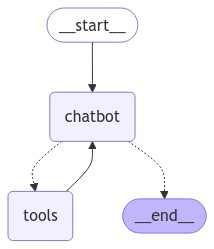

In [31]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [32]:
user_input="Hi there!, My name is John"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is John
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_baa6)
 Call ID: call_baa6
  Args:
    query: John


/home/itskripesh/miniconda3/envs/lang/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/itskripesh/miniconda3/envs/lang/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_nc0z)
 Call ID: call_nc0z
  Args:
    query: John Doe
================================= Tool Message =================================
Name: wikipedia

Page: John Doe
Summary: John Doe (male) and Jane Doe (female) are multiple-use placeholder names that are used in the British and US-American legal system and aside generally in the United Kingdom and the United States when the true name of a person is unknown or is being intentionally concealed. In
================================== Ai Message ==================================

That's interesting!  Is there anything else you'd like to know about John Doe?


In [33]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_65xt)
 Call ID: call_65xt
  Args:
    query: RLHF
================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning from human feedback
Summary: In machine learning, reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other mo
================================== Ai Message ==================================

Reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences.
